In [1]:
import numpy as np
import emcee
import scipy.stats as stats
import scipy
import matplotlib.pyplot as pl
import pandas as pd
from scipy.interpolate import interp1d, griddata, interpn

## MCMC - example

In [2]:
n = 100 # number of throws
k = 66  # number of times it comes up heads
p = k/n # prob. from data of getting heads

a, b   = 5, 17
thetas = np.linspace(0, 1, 200)

In [3]:
alpha = a
beta  = b

In [4]:
def log_prior(theta):
    a,b = 5,17
    if (theta<0 or theta>1):
        return -np.inf
    return np.log(scipy.stats.beta.pdf(theta,a,b))

def log_Binomial(theta):
    k, n = 61,100
    res = stats.binom.logpmf(k,n,theta)
    if res != 0:
        return res
    else:
        return -np.inf

def log_post(theta):
    lp = log_prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    
    return lp + log_Binomial(theta)

In [5]:
ndim, nwalkers = 1, 2
p0 = [np.random.rand(ndim)*0.1+0.4 for i in range(nwalkers)]

In [6]:
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_post)
nburn  = 10
nsteps = 2000
state = sampler.run_mcmc(p0, nburn)
sampler.reset()
sampler.run_mcmc(state, nsteps);

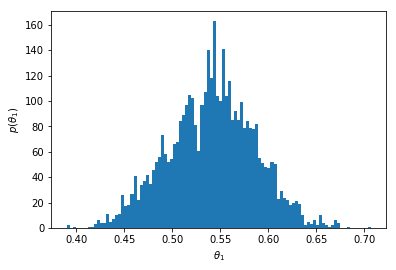

In [7]:
samples = sampler.get_chain(flat=True)
pl.hist(samples[:, 0], 100)
pl.xlabel(r"$\theta_1$");
pl.ylabel(r"$p(\theta_1)$");

In [8]:
np.shape(sampler.chain[:, :, :]) # nwalkers x nsteps x ndim

(2, 2000, 1)

In [9]:
np.shape(samples)

(4000, 1)

## Chi2/LLH function

In [10]:
d = np.linspace(36, 39, 2, endpoint=True)
wave = np.load("wave.npy")[0]
data = np.load("grid_data.npy")
xspec = pd.read_csv('../TARDIS/AT2017gfo_Phase1.dat',usecols=[0,1], delimiter='\t',header=None,skiprows=1)

In [11]:
new_p = np.zeros((2,2,2,2,2),dtype=object)
new_data = np.zeros((2,2,2,2,2),dtype=object)
for i in range(2):
    for j in range(2):
        for k in range(2):
            for l in range(2):
                for m in range(2):
                    new_p[i,j,k,l,m] = np.append(d[i],data[0,j,k,l,m])
                    new_data[i,j,k,l,m] = data[1,j,k,l,m]/((1+0.0099)*4*np.pi*(d[i]*3.08567758128E+24)**2)

final_data = np.stack([new_p,new_data])

In [12]:
print(np.shape(final_data))

(2, 2, 2, 2, 2, 2)


In [13]:
obs = xspec[1][xspec[0].notna()]

chi2 = np.zeros_like(final_data[1])
for i in range(2):
    for j in range(2):
        for k in range(2):
            for l in range(2):
                for m in range(2):
                    spline = interp1d(wave, final_data[1,i,j,k,l,m][0]) #OBS linear spline
                    exp = spline(xspec[0][xspec[0].notna()])
                    chi2[i,j,k,l,m] = np.sum((obs-exp)**2/exp)


In [14]:
print((final_data[0][np.where(chi2 == np.min(chi2))]))
print((chi2[np.where(chi2 == np.min(chi2))]))
print(final_data[0][0,0,0,0,0])
print(final_data[0][1,1,1,1,1])

[array([3.60000000e+01, 3.11111111e+41, 2.00000000e-16, 1.00000000e+08,
       1.06000000e+08])]
[2.1539051583409481e-13]
[3.60e+01 3.00e+41 2.00e-16 7.00e+07 1.02e+08]
[3.90000000e+01 3.11111111e+41 2.11111111e-16 1.00000000e+08
 1.06000000e+08]


In [15]:
# points = []
# values = []
# for i in range(2):
#     for j in range(2):
#         for k in range(2):
#             for l in range(2):
#                 for m in range(2):
#                     values.append(chi2[i,j,k,l,m])
#                     points.append(tuple(final_data[0][i,j,k,l,m]))

In [61]:
d = np.linspace(final_data[0][0,0,0,0,0][0], final_data[0][1,1,1,1,1][0], 2)
l = np.linspace(final_data[0][0,0,0,0,0][1], final_data[0][1,1,1,1,1][1], 2)
rho = np.linspace(final_data[0][0,0,0,0,0][2], final_data[0][1,1,1,1,1][2], 2)
vstart = np.linspace(final_data[0][0,0,0,0,0][3], final_data[0][1,1,1,1,1][3], 2)
vstop = np.linspace(final_data[0][0,0,0,0,0][4], final_data[0][1,1,1,1,1][4], 2)

points = (d,l,rho,vstart,vstop)

In [62]:
point = np.array([37, 3.1e41, 2.1e-16, 0.8e8, 1.04e8])
point = np.array([3.60000000e+01, 3.11111111e+41, 2.00000000e-16, 1.00000000e+08,1.06000000e+08])
print(interpn(points, chi2, point))

[2.15390517e-13]


## MCMC

In [71]:
def log_prior(theta):
#    d,l,rho,vstart,vstop = theta
    if (theta[0]<d[0] or theta[0]>d[-1]):
        return -np.inf
    elif (theta[1]<l[0] or theta[1]>l[-1]):
        return -np.inf
    elif (theta[2]<rho[0] or theta[2]>rho[-1]):
        return -np.inf
    elif (theta[3]<vstart[0] or theta[3]>vstart[-1]):
        return -np.inf
    elif (theta[4]<vstop[0] or theta[4]>vstop[-1]):
        return -np.inf
    return 0.0

def log_llh(theta):
#    d,l,rho,vstart,vstop = theta
    param = np.array([theta])
    res = interpn(points, -chi2, param)
    if res != 0:
        return res
    else:
        return -np.inf

def log_post(theta):
    lp = log_prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_llh(theta)

In [72]:
log_post([3.60000000e+01, 3.11111111e+41, 2.00000000e-16, 1.00000000e+08,1.06000000e+08])

array([-2.15390517e-13])

In [73]:
ndim, nwalkers = 5, 10

d0 = np.random.uniform(d[0],d[-1],size=nwalkers)
l0 = np.random.uniform(l[0],l[-1],size=nwalkers)
rho0 = np.random.uniform(rho[0],rho[-1],size=nwalkers)
vstart0 = np.random.uniform(vstart[0],vstart[-1],size=nwalkers)
vstop0 = np.random.uniform(vstop[0],vstop[-1],size=nwalkers)

p0 = []
for i in range(nwalkers):
    p0.append(np.array([d0[i],l0[i],rho0[i],vstart0[i],vstop0[i]]))

In [74]:
rho[1]

2.1111111111111112e-16

In [75]:
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_post)
nburn  = 10
nsteps = 2000
state = sampler.run_mcmc(p0, nburn)
sampler.reset()
sampler.run_mcmc(state, nsteps, progress = True);

100%|██████████| 2000/2000 [00:17<00:00, 113.48it/s]


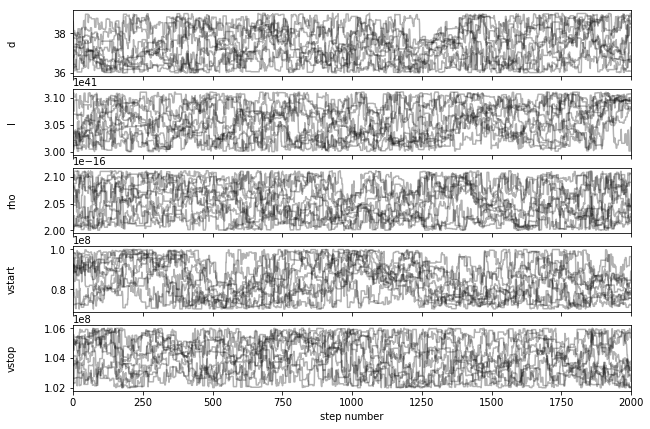

In [76]:
fig, axes = pl.subplots(5, figsize=(10, 7), sharex=True)
samples = sampler.get_chain()
labels = ["d", "l", "rho", "vstart", "vstop"]
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number");

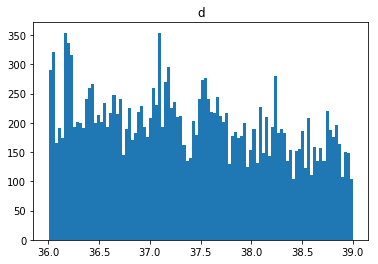

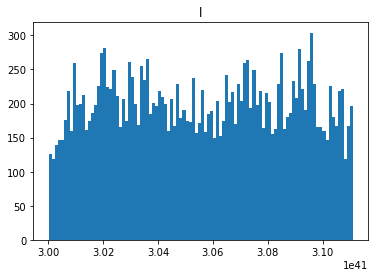

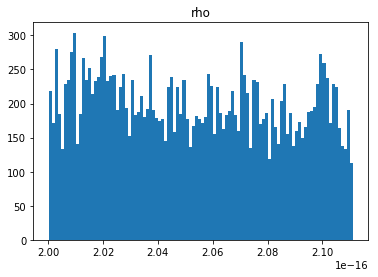

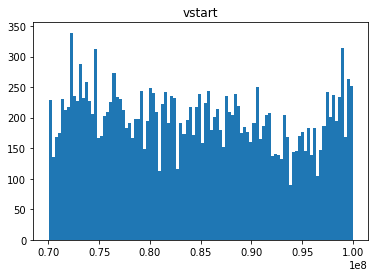

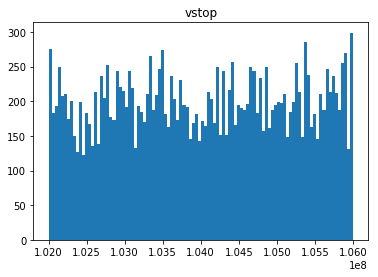

In [80]:
samples = sampler.get_chain(flat=True)
for i in range(ndim):
    pl.hist(samples[:, i], 100)
    pl.title(labels[i])
    pl.show()